# Importation des librairies et des données

In [1]:
import pandas as pd
import numpy as np
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE #importation du SMOTE pour réequilibrage du dataset

from sklearn.metrics import r2_score, ConfusionMatrixDisplay, recall_score, accuracy_score, precision_score, classification_report


In [27]:
url = f"https://docs.google.com/spreadsheets/d/1PIMO76csrwWa7eRCZHQziJQvqGMy7M_EpZLblZjRFMU/gviz/tq?tqx=out:csv&sheet=dataset_clean"
df_ml = pd.read_csv(url)
df_ml

,age,attrition,deplacements_pro,service,trajet_quotidien_en_miles,num_niveau_detude,domaine_detude,identifiant_employe,num_satisfaction_environnement,genre,...,pourcentage_augmentation,niveau_carriere,temps_de_formation,anciennete,anciennete_poste,derniere_promotion,annees_avec_manager,prenom,nom,email
0,41,Oui,Rare,Ventes,1,2,Sciences,1,2,Femme,...,11 - 12,06 - 10,0,06 - 10,03 - 05,0 - 02,03 - 05,Rose,Atkins,r.atkins@ibm-data.com
1,49,Non,Fréquent,R&D,8,1,Sciences,2,3,Homme,...,21 +,06 - 10,01 - 03,06 - 10,06 - 10,0 - 02,06 - 10,Timothy,Davis,t.davis@ibm-data.com
2,37,Oui,Rare,R&D,2,2,Autre,4,4,Homme,...,15 - 20,06 - 10,01 - 03,0 - 02,0 - 02,0 - 02,0 - 02,Harold,Newman,h.newman@ibm-data.com
3,33,Non,Fréquent,R&D,3,4,Sciences,5,4,Femme,...,11 - 12,06 - 10,01 - 03,06 - 10,06 - 10,03 - 05,0 - 02,Michelle,Olson,m.olson@ibm-data.com
4,27,Non,Rare,R&D,2,1,Médecine,7,1,Homme,...,11 - 12,06 - 10,01 - 03,0 - 02,0 - 02,0 - 02,0 - 02,Richard,Riley,r.riley@ibm-data.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,Non,Fréquent,R&D,23,2,Médecine,2061,3,Homme,...,15 - 20,10 - 20,01 - 03,03 - 05,0 - 02,0 - 02,03 - 05,Ricky,Johnson,r.johnson1@ibm-data.com
1466,39,Non,Rare,R&D,6,1,Médecine,2062,4,Homme,...,15 - 20,06 - 10,04 +,06 - 10,06 - 10,0 - 02,06 - 10,Carlos,Holmes,c.holmes@ibm-data.com
1467,27,Non,Rare,R&D,4,3,Sciences,2064,2,Homme,...,15 - 20,06 - 10,0,06 - 10,0 - 02,0 - 02,03 - 05,Alejandro,Mclaughlin,a.mclaughlin@ibm-data.com
1468,49,Non,Fréquent,Ventes,2,3,Médecine,2065,4,Homme,...,13 - 14,10 - 20,01 - 03,06 - 10,06 - 10,0 - 02,06 - 10,Roger,Green,r.green@ibm-data.com


# Etapes clés avant la création du modèle




In [28]:
#Supprimer les colonnes de sous-catégorisation crées pour Looker mais pas utile pour le machine learning
df_ml.drop(columns=["categorie_age","attrition","service","categorie_trajet","niveau_detude","identifiant_employe",
                    "satisfaction_environnement","implication","niveau_hierarchique","satisfaction_travail",
                    "categorie_salaire","nb_entreprises","pourcentage_augmentation","performance","satisfaction_relation",
                    "taux_daction","niveau_carriere","temps_de_formation","equilibre_pro_perso","anciennete","anciennete_poste",
                    "derniere_promotion","annees_avec_manager","prenom","nom","email"],inplace=True)
#Choix de drop le service car redondant avec l'information du poste : dégrade le modèle

In [29]:
#Encodage d'hommes et femmes
df_ml.loc[df_ml["genre"]=="Femme","genre"]=0
df_ml.loc[df_ml["genre"]=="Homme","genre"]=1

#Castage de la colonne genre en int
df_ml["genre"]=df_ml["genre"].astype(int)

#Encodage heures sup
df_ml.loc[df_ml["heures_sup"]=="Non","heures_sup"]=0
df_ml.loc[df_ml["heures_sup"]=="Oui","heures_sup"]=1

#Castage de la colonne heures sup en int
df_ml["heures_sup"]=df_ml["heures_sup"].astype(int)

#Encodage situation
df_ml.loc[(df_ml["situation"]=="Célibataire") | (df_ml["situation"]=="Divorcé(e)"),"situation"]=0
df_ml.loc[df_ml["situation"]=="Marié(e)","situation"]=1

#Castage de la colonne situation en int
df_ml["situation"]=df_ml["situation"].astype(int)

#Choix de la target et des features
X=df_ml.drop(columns="num_attrition")
y=df_ml["num_attrition"]

#Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Split en numérique et catégorique
X_train_cat=X_train.select_dtypes(exclude="number")
X_train_num=X_train.select_dtypes(include="number")

X_test_cat=X_test.select_dtypes(exclude="number")
X_test_num=X_test.select_dtypes(include="number")

#Encodage
encoder = OneHotEncoder(sparse_output=False).set_output(transform='pandas')
X_train_cat_encoded = encoder.fit_transform(X_train_cat) #fit and transform sur train
X_test_cat_encoded=encoder.transform(X_test_cat) #transform uniquement le test

#Standardisation
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num) #fit et transform sur le train
X_test_num_scaled = scaler.transform(X_test_num) #transform uniquement sur le test

# Conversion en DataFrame en conservant les index et les noms de colonnes
X_train_num_scaled=pd.DataFrame(X_train_num_scaled,columns=X_train_num.columns,index=X_train_num.index)
X_test_num_scaled =pd.DataFrame(X_test_num_scaled,columns=X_test_num.columns,index=X_test_num.index)

#Concaténation des nums et cat
X_train_final =pd.concat([X_train_num_scaled, X_train_cat_encoded], axis=1)
X_test_final = pd.concat([X_test_num_scaled, X_test_cat_encoded], axis=1)

In [40]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   age                             1470 non-null   int64 
 1   deplacements_pro                1470 non-null   object
 2   trajet_quotidien_en_miles       1470 non-null   int64 
 3   num_niveau_detude               1470 non-null   int64 
 4   domaine_detude                  1470 non-null   object
 5   num_satisfaction_environnement  1470 non-null   int64 
 6   genre                           1470 non-null   int64 
 7   num_implication                 1470 non-null   int64 
 8   num_niveau_hierarchique         1470 non-null   int64 
 9   poste                           1470 non-null   object
 10  num_satisfaction_travail        1470 non-null   int64 
 11  situation                       1470 non-null   int64 
 12  salaire_mensuel                 1470 non-null   

In [30]:
# Rééquilibrage (SMOTE) uniquement sur le train
sm = SMOTE(sampling_strategy=0.5, random_state=0)  # 0.5 => minoritaire = 50% de la majoritaire
X_train_reeq, y_train_reeq = sm.fit_resample(X_train_final, y_train)

# Logistic Regression

Initialisation du modèle

In [31]:
model_logistic = LogisticRegression()
model_logistic.fit(X_train_reeq, y_train_reeq) #on entraîne le modèle sur le train

LogisticRegression()

Prédictions

In [32]:
y_pred_log = model_logistic.predict(X_test_final) # on fait des préditions avec le X_test

In [33]:
X_test_final

,age,trajet_quotidien_en_miles,num_niveau_detude,num_satisfaction_environnement,genre,num_implication,num_niveau_hierarchique,num_satisfaction_travail,situation,salaire_mensuel,...,domaine_detude_Techonologies,poste_Chercheur,poste_Commercial,poste_Directeur R&D,poste_Directeur de production,poste_Délégué médical,poste_Manager,poste_RH,poste_Responsable commercial,poste_Technicien de laboratoire
442,-0.088866,0.103290,1.071582,-0.685235,0.805834,0.385478,0.854517,1.149726,-0.896483,0.745592,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1091,-0.419929,1.947455,0.080874,1.139990,0.805834,-1.013665,-0.049994,-0.665143,-0.896483,-0.452840,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
981,-0.199220,1.086844,1.071582,1.139990,-1.240950,0.385478,-0.049994,0.242291,1.115471,-0.390590,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
785,0.352553,1.332733,1.071582,-1.597848,0.805834,0.385478,0.854517,1.149726,1.115471,0.818006,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1332,-0.861348,1.824510,-0.909834,1.139990,0.805834,-1.013665,-0.954505,1.149726,-0.896483,-0.851118,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,-0.088866,-0.757320,0.080874,-1.597848,-1.240950,-1.013665,0.854517,1.149726,1.115471,0.250974,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
481,-0.309575,-1.003209,-0.909834,-0.685235,0.805834,-1.013665,-0.954505,1.149726,1.115471,-0.600633,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
124,-0.640639,-0.388487,1.071582,-0.685235,0.805834,-2.412809,-0.049994,0.242291,1.115471,-0.060703,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
198,0.131844,-0.880265,1.071582,1.139990,0.805834,0.385478,-0.049994,0.242291,1.115471,0.019969,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [36]:
test=X_test_final.loc[1,]
test=pd.DataFrame(test).T
test

,age,trajet_quotidien_en_miles,num_niveau_detude,num_satisfaction_environnement,genre,num_implication,num_niveau_hierarchique,num_satisfaction_travail,situation,salaire_mensuel,...,domaine_detude_Techonologies,poste_Chercheur,poste_Commercial,poste_Directeur R&D,poste_Directeur de production,poste_Délégué médical,poste_Manager,poste_RH,poste_Responsable commercial,poste_Technicien de laboratoire
1,1.345745,-0.142599,-1.900542,0.227377,0.805834,-1.013665,-0.049994,-0.665143,1.115471,-0.281333,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
y_proba=model_logistic.predict_proba(test)
y_proba

array([[0.95164015, 0.04835985]])

Métriques de performances

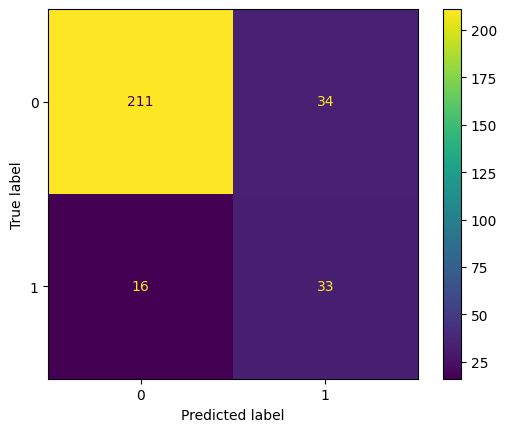

In [37]:
confusion_matrix_log = ConfusionMatrixDisplay.from_estimator(model_logistic, X_test_final, y_test)

Le modèle prédit que 211 personnes restent et ces personnes restent OK

Le modèle prédit que 34 personnes partent alors qu'elles restent  : dans notre cas ce n'est pas grave on crée une alerte pour rien mais pas gravissime

Le modèle prédit que 16 personnes restent alors qu'elles partents : erreur à réduire au maximum dans notre cas

Le modèle prédit que 33 personnes partent et ces personnes partent. OK

In [38]:
log_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred_log)
log_recall = recall_score(y_true=y_test, y_pred=y_pred_log)
log_precision=precision_score(y_true=y_test, y_pred=y_pred_log)

print (f"L'accuracy du modèle est de {log_accuracy}")
print (f"Le recall du modèle est de {log_recall}")
print (f"La précision du modèle est de {log_precision}")

L'accuracy du modèle est de 0.8299319727891157
Le recall du modèle est de 0.673469387755102
La précision du modèle est de 0.4925373134328358


In [39]:
print(classification_report(y_true=y_test, y_pred=y_pred_log))

              precision    recall  f1-score   support

           0       0.93      0.86      0.89       245
           1       0.49      0.67      0.57        49

    accuracy                           0.83       294
   macro avg       0.71      0.77      0.73       294
weighted avg       0.86      0.83      0.84       294



**Shap**

SHAP permet de visualiser l'importance globale de chaque feature. Grâce au fait que les valeurs sont calculées pour chaque exemple du dataset, il est possible de représenter chaque exemple par un point  et ainsi avoir une information supplémentaire sur l’impact de la variable en fonction de sa valeur.

In [ ]:
# Fits the explainer
explainer_log = shap.Explainer(model_logistic.predict, X_test_final)
# Calculates the SHAP values - It takes some time
shap_values_log = explainer_log(X_test_final)

PermutationExplainer explainer: 295it [00:13, 11.61it/s]                         


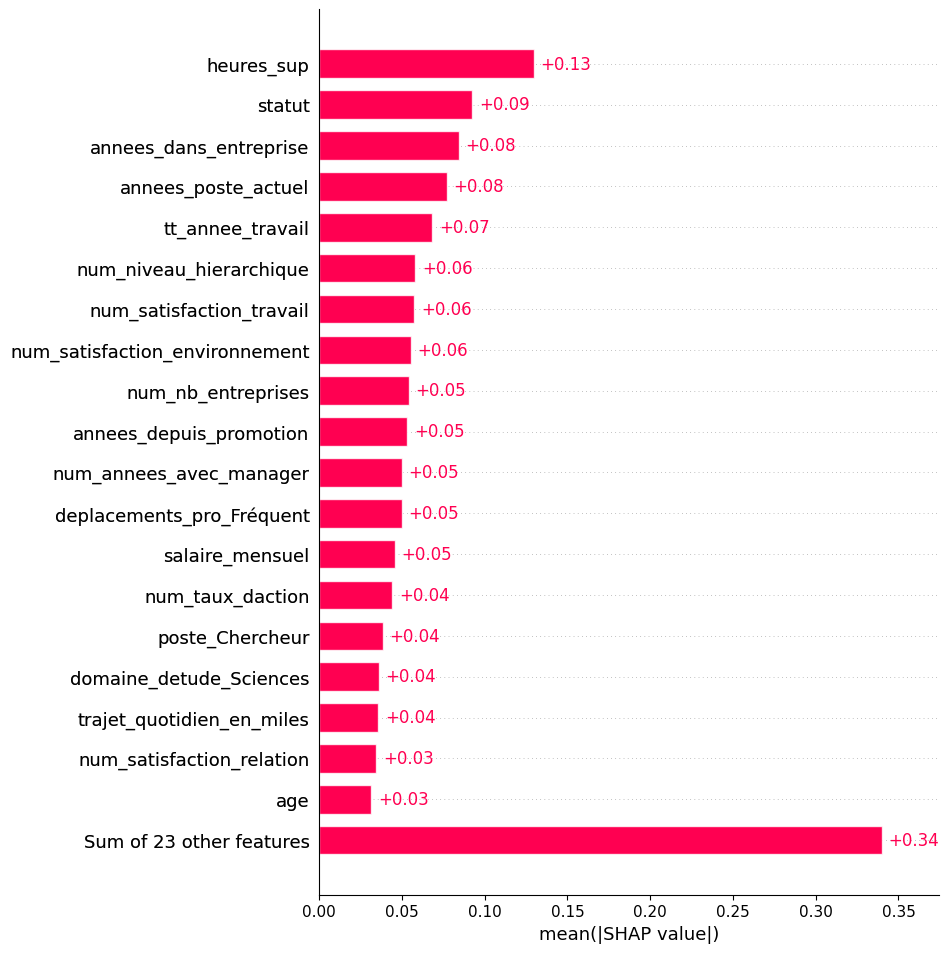

In [ ]:
shap.plots.bar(shap_values_log,max_display=20)

/tmp/ipython-input-2248993212.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_log)


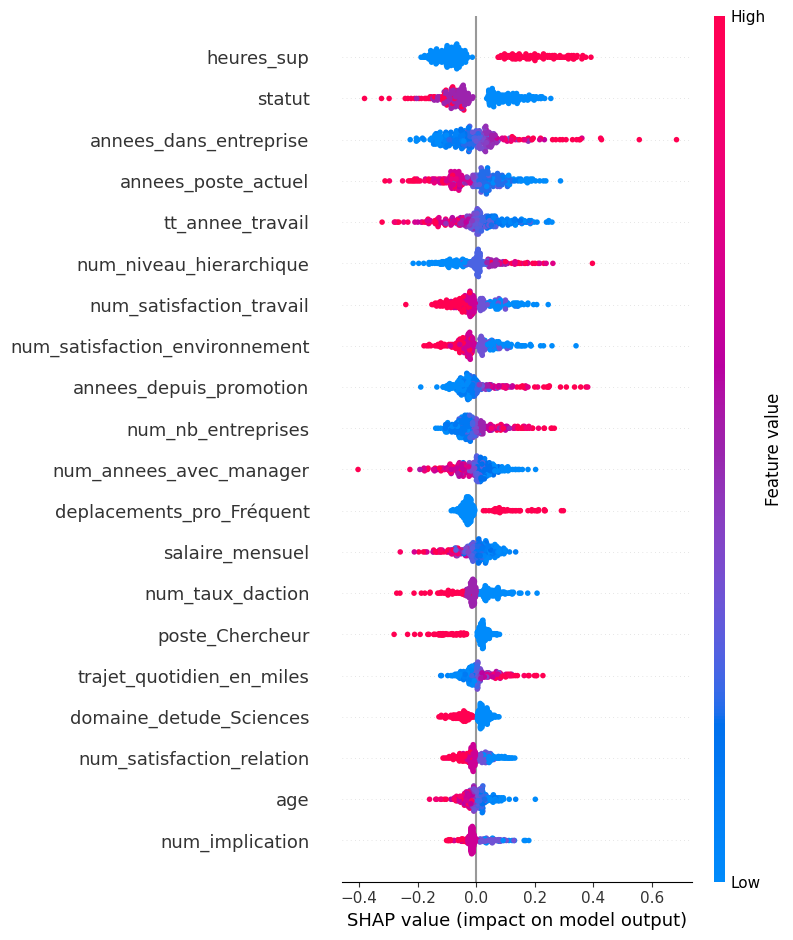

In [ ]:
shap.summary_plot(shap_values_log)


# AdaBoost

Initialisation du modèle

In [ ]:
model_ada = AdaBoostClassifier()
model_ada.fit(X_train_reeq,y_train_reeq)

AdaBoostClassifier()

Prédictions

In [ ]:
y_pred_ada=model_ada.predict(X_test_final)

Métriques de performance

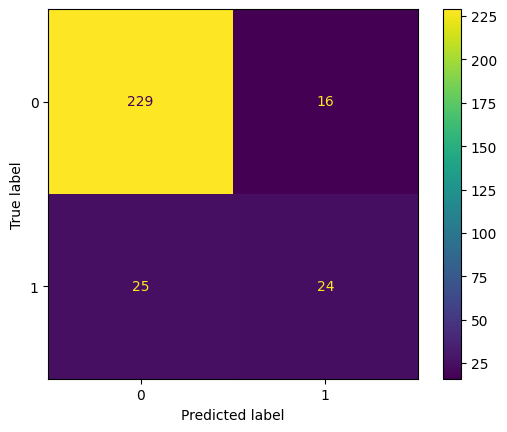

In [ ]:
confusion_matrix_ada = ConfusionMatrixDisplay.from_estimator(model_ada, X_test_final, y_test)

In [ ]:
ada_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred_ada)
ada_recall = recall_score(y_true=y_test, y_pred=y_pred_ada)
ada_precision=precision_score(y_true=y_test, y_pred=y_pred_ada)

print (f"L'accuracy du modèle est de {ada_accuracy}")
print (f"Le recall du modèle est de {ada_recall}") #0,53 avant d'encoder en une colonne situation marital et heures supp
print (f"La précision du modèle est de {ada_precision}")

L'accuracy du modèle est de 0.8605442176870748
Le recall du modèle est de 0.4897959183673469
La précision du modèle est de 0.6


In [ ]:
print(classification_report(y_true=y_test, y_pred=y_pred_ada))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92       245
           1       0.60      0.49      0.54        49

    accuracy                           0.86       294
   macro avg       0.75      0.71      0.73       294
weighted avg       0.85      0.86      0.85       294



**Shap**

In [ ]:
# Fits the explainer
explainer_ada = shap.Explainer(model_ada.predict, X_test_final)
# Calculates the SHAP values - It takes some time
shap_values_ada = explainer_ada(X_test_final)

PermutationExplainer explainer: 295it [01:04,  3.84it/s]


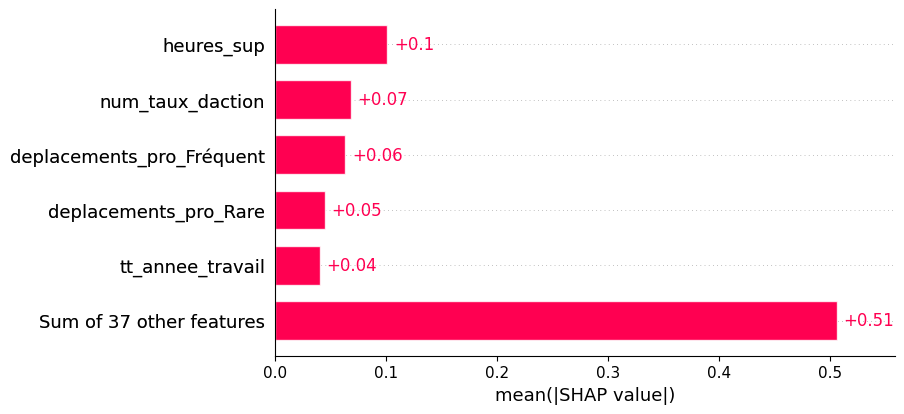

In [ ]:
shap.plots.bar(shap_values_ada,max_display=6)

/tmp/ipython-input-2129181290.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_ada)


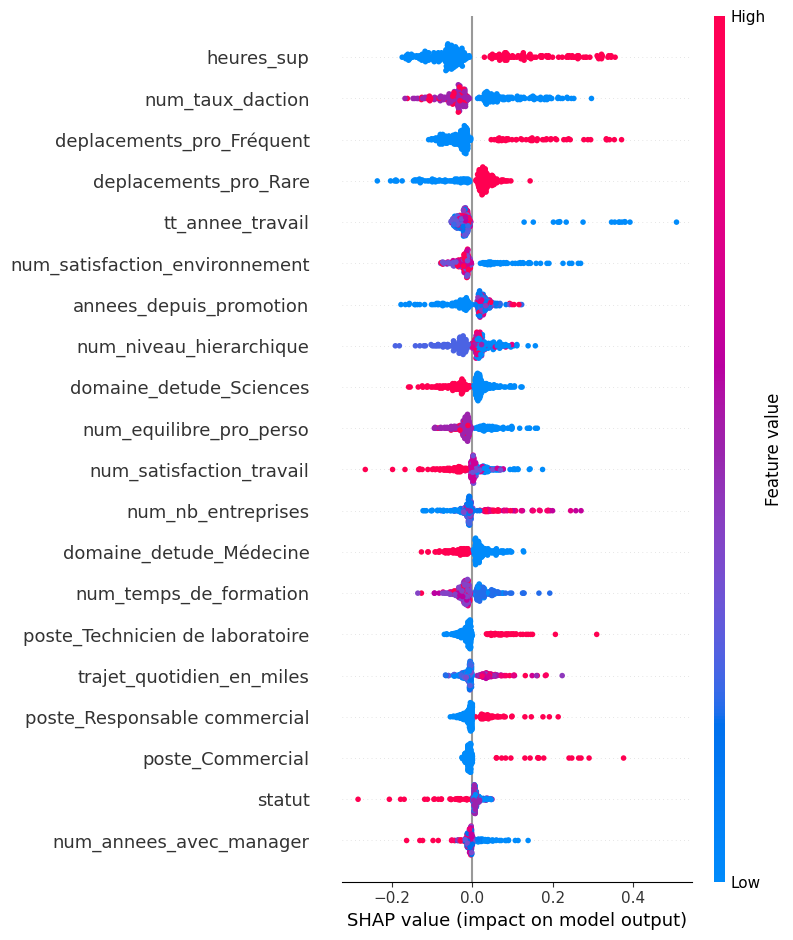

In [ ]:
shap.summary_plot(shap_values_ada)

# XGBoost

Initialisation du modèle

In [ ]:
model_xg = XGBClassifier()
model_xg.fit(X_train_reeq,y_train_reeq)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

Prédictions

In [ ]:
y_pred_xg=model_xg.predict(X_test_final)

Métriques de performance

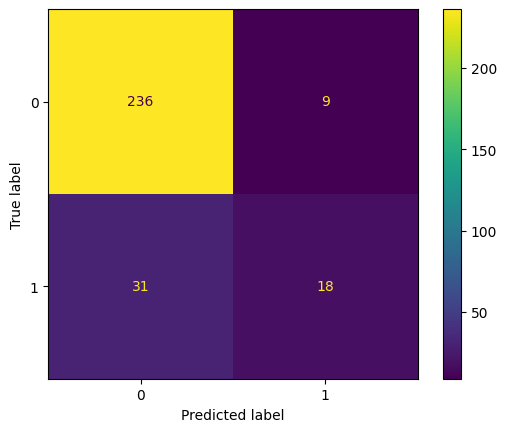

In [ ]:
confusion_matrix_xg = ConfusionMatrixDisplay.from_estimator(model_xg, X_test_final, y_test)

In [ ]:
xg_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred_xg)
xg_recall = recall_score(y_true=y_test, y_pred=y_pred_xg)
xg_precision=precision_score(y_true=y_test, y_pred=y_pred_xg)

print (f"L'accuracy du modèle est de {xg_accuracy}")
print (f"Le recall du modèle est de {xg_recall}") #0,38 avant 0,36 après encodage en une colonne de heures supp et de marital
print (f"La précision du modèle est de {xg_precision}")

L'accuracy du modèle est de 0.8639455782312925
Le recall du modèle est de 0.3673469387755102
La précision du modèle est de 0.6666666666666666


In [ ]:
print(classification_report(y_true=y_test, y_pred=y_pred_xg))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       245
           1       0.67      0.37      0.47        49

    accuracy                           0.86       294
   macro avg       0.78      0.67      0.70       294
weighted avg       0.85      0.86      0.85       294



In [ ]:
# Fits the explainer
explainer_xg = shap.Explainer(model_xg.predict, X_test_final)
# Calculates the SHAP values - It takes some time
shap_values_xg = explainer_xg(X_test_final)

PermutationExplainer explainer: 295it [00:37,  5.86it/s]


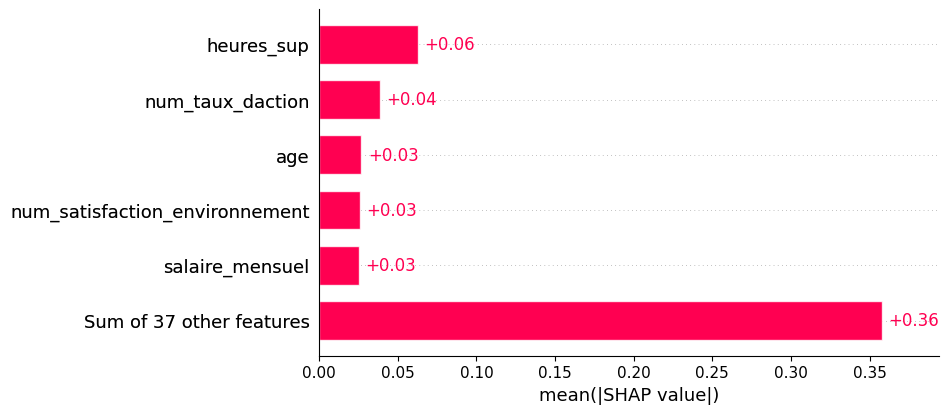

In [ ]:
shap.plots.bar(shap_values_xg,max_display=6)

/tmp/ipython-input-3195073270.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_xg)


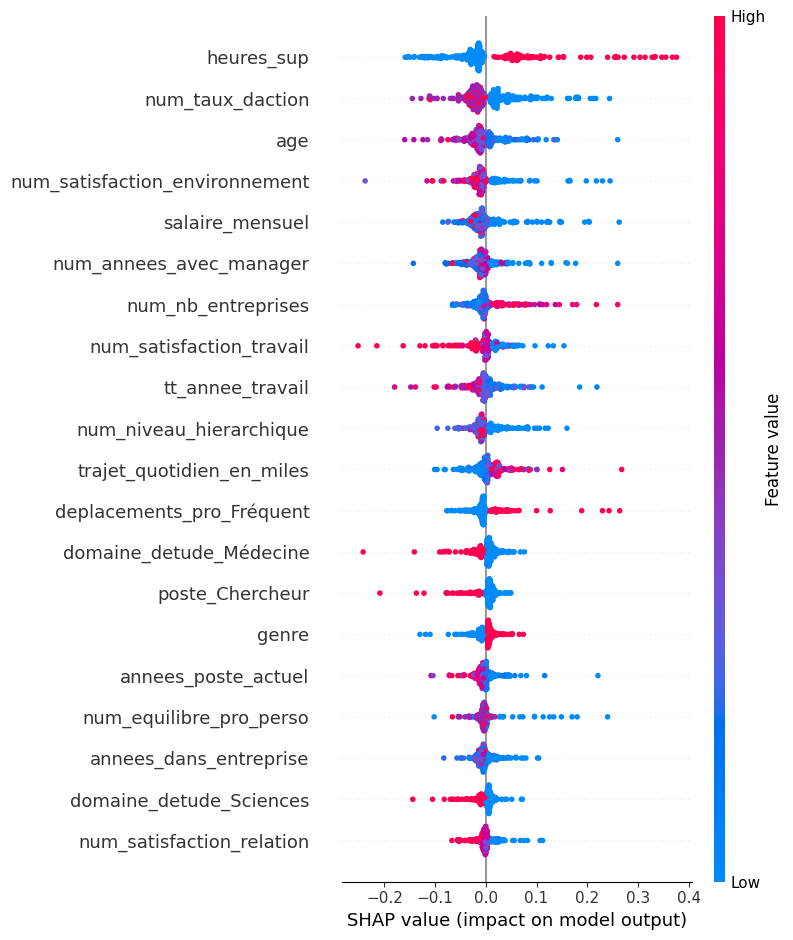

In [ ]:
shap.summary_plot(shap_values_xg)

# Test pour Guillaume

Choix des colonnes :
- Age
- Heures supplémentaires
- Années dans l'entreprise
- Salaire mensuel
- Situation marital
- Niveau hiérarchique
- Année avec le manager
- Année dernière promototion
- Satisfaction relationnelle
- Poste

In [ ]:
#Supprimer les colonnes
df_ml_20=df_ml[["heures_sup","statut","annees_dans_entreprise","annees_poste_actuel","tt_annee_travail","num_niveau_hierarchique","num_satisfaction_travail","num_satisfaction_environnement","annees_depuis_promotion","num_nb_entreprises","num_annees_avec_manager","deplacements_pro","salaire_mensuel","num_taux_daction","poste","trajet_quotidien_en_miles","domaine_detude","age","num_satisfaction_relation","num_implication","num_attrition"]]

#Encodage heures sup
df_ml_20.loc[df_ml_20["heures_sup"]=="Non","heures_sup"]=0
df_ml_20.loc[df_ml_20["heures_sup"]=="Oui","heures_sup"]=1

#Castage de la colonne heures sup en int
df_ml_20["heures_sup"]=df_ml_20["heures_sup"].astype(int)

#Choix de la target et des features
X_light=df_ml_20.drop(columns="num_attrition")
y_light=df_ml_20["num_attrition"]

#Split train/test
X_train_light, X_test_light, y_train_light, y_test_light = train_test_split(X_light, y_light, test_size=0.2, random_state=0)

#Split en numérique et catégorique
X_train_cat_light=X_train_light.select_dtypes(exclude="number")
X_train_num_light=X_train_light.select_dtypes(include="number")

X_test_cat_light=X_test_light.select_dtypes(exclude="number")
X_test_num_light=X_test_light.select_dtypes(include="number")

#Encodage
encoder = OneHotEncoder(sparse_output=False).set_output(transform='pandas')
X_train_cat_light_encoded = encoder.fit_transform(X_train_cat_light) #fit and transform sur train
X_test_cat_light_encoded=encoder.transform(X_test_cat_light) #transform uniquement le test

#Supprimer les colonnes non nécessaires qui ont été encodés mais qui ne sont pas dans le TOP 20 du SHAP
X_train_cat_light_encoded=X_train_cat_light_encoded[["deplacements_pro_Rare","poste_Chercheur","domaine_detude_Sciences"]]
X_test_cat_light_encoded=X_test_cat_light_encoded[["deplacements_pro_Rare","poste_Chercheur","domaine_detude_Sciences"]]

#Standardisation
scaler = StandardScaler()
X_train_num_light_scaled = scaler.fit_transform(X_train_num_light) #fit et transform sur le train
X_test_num_light_scaled = scaler.transform(X_test_num_light) #transform uniquement sur le test

# Conversion en DataFrame en conservant les index et les noms de colonnes
X_train_num_light_scaled=pd.DataFrame(X_train_num_light_scaled,columns=X_train_num_light.columns,index=X_train_num_light.index)
X_test_num_light_scaled =pd.DataFrame(X_test_num_light_scaled,columns=X_test_num_light.columns,index=X_test_num_light.index)

#Concaténation des nums et cat
X_train_light_final =pd.concat([X_train_num_light_scaled, X_train_cat_light_encoded], axis=1)
X_test_light_final = pd.concat([X_test_num_light_scaled, X_test_cat_light_encoded], axis=1)

/tmp/ipython-input-2470761226.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml_20["heures_sup"]=df_ml_20["heures_sup"].astype(int)


In [ ]:
# Rééquilibrage (SMOTE) uniquement sur le train
sm = SMOTE(sampling_strategy=0.5, random_state=0)  # 0.5 => minoritaire = 50% de la majoritaire
X_train_light_reeq, y_train_light_reeq = sm.fit_resample(X_train_light_final, y_train_light)

In [ ]:
model_logistic_light = LogisticRegression()
model_logistic_light.fit(X_train_light_reeq, y_train_light_reeq) #on entraîne le modèle sur le train

LogisticRegression()

In [ ]:
y_pred_light_log = model_logistic_light.predict(X_test_light_final) # on fait des préditions avec le X_test

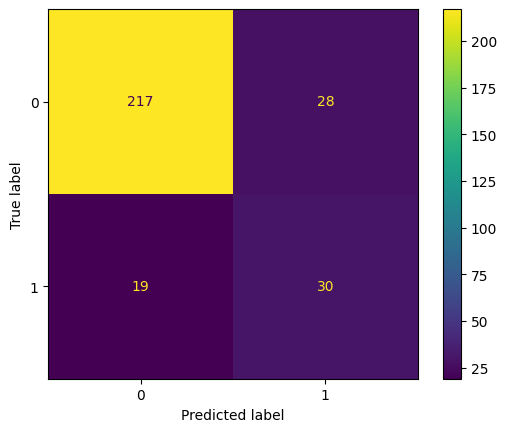

In [ ]:
confusion_matrix_log_light = ConfusionMatrixDisplay.from_estimator(model_logistic_light, X_test_light_final, y_test_light)

In [ ]:
log_accuracy_light = accuracy_score(y_true=y_test_light, y_pred=y_pred_light_log)
log_recall_light = recall_score(y_true=y_test_light, y_pred=y_pred_light_log)
log_precision_light=precision_score(y_true=y_test_light, y_pred=y_pred_light_log)

print (f"L'accuracy du modèle est de {log_accuracy_light}")
print (f"Le recall du modèle est de {log_recall_light}")
print (f"La précision du modèle est de {log_precision_light}")

L'accuracy du modèle est de 0.8401360544217688
Le recall du modèle est de 0.6122448979591837
La précision du modèle est de 0.5172413793103449


In [ ]:
print(classification_report(y_true=y_test, y_pred=y_pred_light_log))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       245
           1       0.52      0.61      0.56        49

    accuracy                           0.84       294
   macro avg       0.72      0.75      0.73       294
weighted avg       0.85      0.84      0.85       294

